# **COVID-19 Analysis, Visualization, Comparison and Pridictions**

# Imports and Datasets
<hr> 
* Pandas - for dataset handeling
* Numpy - Support for Pandas and calculations 
* Matplotlib - for visualization (Platting graphas)
* pycountry_convert - Library for getting continent (name) to from their country names
* folium - Library for Map
* keras - Prediction Models
* plotly - for interative plots

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker 
import pycountry_convert as pc
import folium
import branca
from datetime import datetime, timedelta,date
from scipy.interpolate import make_interp_spline, BSpline
import plotly.express as px
import json, requests
import calmap

from keras.layers import Input, Dense, Activation, LeakyReLU
from keras import models
from keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


### 2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE ([LINK](https://github.com/CSSEGISandData/COVID-19)) 
<hr>
Dataset consists of time-series data from 22 JAN 2020 to Till date (Updated on daily Basis).<br>
**Three Time-series dataset (Depricated):**
* time_series_19-covid-Confirmed.csv ([Link Raw File](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv))
* time_series_19-covid-Deaths.csv ([Link Raw File](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv))
* time_series_19-covid-Recovered.csv ([Link Raw File](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv))

**New Time-series dataset:**
* time_series_covid19_confirmed_global.csv ([Link Raw File](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv))
* time_series_covid19_deaths_global ([Link Raw File](https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv))

**New Dataset (Updated more frequently by web crawler of JHU):**
* cases_country.csv ([Link Raw File]("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv"))

In [3]:
# Retriving Dataset
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

# Depricated
# df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
df_covid19 = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_country.csv")
df_table = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/web-data/data/cases_time.csv",parse_dates=['Last_Update'])

In [4]:
# new dataset 
df_covid19 = df_covid19.drop(["People_Tested","People_Hospitalized","UID","ISO3","Mortality_Rate"],axis =1)
df_covid19.head(2)

,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate
0,Australia,2020-04-14 20:30:42,-25.0000,133.0000,6415,62,2186,4167,25.196683
1,Austria,2020-04-14 20:23:04,47.5162,14.5501,14226,384,7633,6209,157.954344


In [5]:
df_confirmed.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,299,349,367,423,444,484,521,555,607,665
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,333,361,377,383,400,409,416,433,446,467


# Preprocessing 
<hr>

In [6]:
df_confirmed = df_confirmed.rename(columns={"Province/State":"state","Country/Region": "country"})
df_deaths = df_deaths.rename(columns={"Province/State":"state","Country/Region": "country"})
df_covid19 = df_covid19.rename(columns={"Country_Region": "country"})
df_covid19["Active"] = df_covid19["Confirmed"]-df_covid19["Recovered"]-df_covid19["Deaths"]
# df_recovered = df_recovered.rename(columns={"Province/State":"state","Country/Region": "country"})

In [7]:
# Changing the conuntry names as required by pycountry_convert Lib
df_confirmed.loc[df_confirmed['country'] == "US", "country"] = "USA"
df_deaths.loc[df_deaths['country'] == "US", "country"] = "USA"
df_covid19.loc[df_covid19['country'] == "US", "country"] = "USA"
df_table.loc[df_table['Country_Region'] == "US", "Country_Region"] = "USA"
# df_recovered.loc[df_recovered['country'] == "US", "country"] = "USA"


df_confirmed.loc[df_confirmed['country'] == 'Korea, South', "country"] = 'South Korea'
df_deaths.loc[df_deaths['country'] == 'Korea, South', "country"] = 'South Korea'
df_covid19.loc[df_covid19['country'] == "Korea, South", "country"] = "South Korea"
df_table.loc[df_table['Country_Region'] == "Korea, South", "Country_Region"] = "South Korea"
# df_recovered.loc[df_recovered['country'] == 'Korea, South', "country"] = 'South Korea'

df_confirmed.loc[df_confirmed['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_deaths.loc[df_deaths['country'] == 'Taiwan*', "country"] = 'Taiwan'
df_covid19.loc[df_covid19['country'] == "Taiwan*", "country"] = "Taiwan"
df_table.loc[df_table['Country_Region'] == "Taiwan*", "Country_Region"] = "Taiwan"
# df_recovered.loc[df_recovered['country'] == 'Taiwan*', "country"] = 'Taiwan'

df_confirmed.loc[df_confirmed['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Kinshasa)", "country"] = "Democratic Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Kinshasa)", "Country_Region"] = "Democratic Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Kinshasa)', "country"] = 'Democratic Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_deaths.loc[df_deaths['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_covid19.loc[df_covid19['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"
df_table.loc[df_table['Country_Region'] == "Cote d'Ivoire", "Country_Region"] = "Côte d'Ivoire"
# df_recovered.loc[df_recovered['country'] == "Cote d'Ivoire", "country"] = "Côte d'Ivoire"

df_confirmed.loc[df_confirmed['country'] == "Reunion", "country"] = "Réunion"
df_deaths.loc[df_deaths['country'] == "Reunion", "country"] = "Réunion"
df_covid19.loc[df_covid19['country'] == "Reunion", "country"] = "Réunion"
df_table.loc[df_table['Country_Region'] == "Reunion", "Country_Region"] = "Réunion"
# df_recovered.loc[df_recovered['country'] == "Reunion", "country"] = "Réunion"

df_confirmed.loc[df_confirmed['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_deaths.loc[df_deaths['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'
df_covid19.loc[df_covid19['country'] == "Congo (Brazzaville)", "country"] = "Republic of the Congo"
df_table.loc[df_table['Country_Region'] == "Congo (Brazzaville)", "Country_Region"] = "Republic of the Congo"
# df_recovered.loc[df_recovered['country'] == 'Congo (Brazzaville)', "country"] = 'Republic of the Congo'

df_confirmed.loc[df_confirmed['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_deaths.loc[df_deaths['country'] == 'Bahamas, The', "country"] = 'Bahamas'
df_covid19.loc[df_covid19['country'] == "Bahamas, The", "country"] = "Bahamas"
df_table.loc[df_table['Country_Region'] == "Bahamas, The", "Country_Region"] = "Bahamas"
# df_recovered.loc[df_recovered['country'] == 'Bahamas, The', "country"] = 'Bahamas'

df_confirmed.loc[df_confirmed['country'] == 'Gambia, The', "country"] = 'Gambia'
df_deaths.loc[df_deaths['country'] == 'Gambia, The', "country"] = 'Gambia'
df_covid19.loc[df_covid19['country'] == "Gambia, The", "country"] = "Gambia"
df_table.loc[df_table['Country_Region'] == "Gambia", "Country_Region"] = "Gambia"
# df_recovered.loc[df_recovered['country'] == 'Gambia, The', "country"] = 'Gambia'

# getting all countries
countries = np.asarray(df_confirmed["country"])
countries1 = np.asarray(df_covid19["country"])
# Continent_code to Continent_names
continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU' : 'Europe',
    'na' : 'Others'
}

# Defininng Function for getting continent code for country.
def country_to_continent_code(country):
    try:
        return pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))
    except :
        return 'na'

#Collecting Continent Information
df_confirmed.insert(2,"continent", [continents[country_to_continent_code(country)] for country in countries[:]])
df_deaths.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]])
df_covid19.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in countries1[:]])
df_table.insert(1,"continent",  [continents[country_to_continent_code(country)] for country in df_table["Country_Region"].values])
# df_recovered.insert(2,"continent",  [continents[country_to_continent_code(country)] for country in countries[:]] )   

In [8]:
df_table = df_table[df_table["continent"] != "Others"]

In [9]:
df_deaths[df_deaths["continent" ]== 'Others']

,state,country,continent,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,...,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20
88,NaN,Diamond Princess,Others,0.000000,0.000000,0,0,0,0,0,...,11,11,11,11,11,11,11,11,11,11
127,NaN,Holy See,Others,41.902900,12.453400,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,NaN,Timor-Leste,Others,-8.874217,125.727539,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241,NaN,West Bank and Gaza,Others,31.952200,35.233200,0,0,0,0,0,...,1,1,1,1,1,1,2,2,2,2
247,NaN,Kosovo,Others,42.602636,20.902977,0,0,0,0,0,...,1,1,1,4,5,5,7,7,7,7
248,NaN,Burma,Others,21.916200,95.956000,0,0,0,0,0,...,1,1,1,1,3,3,3,3,4,4
252,NaN,MS Zaandam,Others,0.000000,0.000000,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
261,NaN,Western Sahara,Others,24.215500,-12.885800,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# df_active = df_confirmed.copy()
# df_active.iloc[:,5:] = df_active.iloc[:,5:] - df_recovered.iloc[:,5:] - df_deaths.iloc[:,5:]
# df_active.head(5)

In [11]:
df_confirmed = df_confirmed.replace(np.nan, '', regex=True)
df_deaths = df_deaths.replace(np.nan, '', regex=True)
# df_recovered = df_recovered.replace(np.nan, '', regex=True)
# df_active = df_active.replace(np.nan, '', regex=True)

 # Defining Functions
 <hr>
* plot_params()
* visualize_covid_cases()
* get_mortality_rate()

In [12]:
def plot_params(ax,axis_label= None, plt_title = None,label_size=15, axis_fsize = 15, title_fsize = 20, scale = 'linear' ):
    # Tick-Parameters
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', width=1,labelsize=label_size)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3, color='0.8')
    
    # Grid
    plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
    plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

    # Plot Title
    plt.title( plt_title,{'fontsize':title_fsize})
    
    # Yaxis sacle
    plt.yscale(scale)
    plt.minorticks_on()
    # Plot Axes Labels
    xl = plt.xlabel(axis_label[0],fontsize = axis_fsize)
    yl = plt.ylabel(axis_label[1],fontsize = axis_fsize)
    
def visualize_covid_cases(confirmed, deaths, continent=None , country = None , state = None, period = None, figure = None, scale = "linear"):
    x = 0
    if figure == None:
        f = plt.figure(figsize=(10,10))
        # Sub plot
        ax = f.add_subplot(111)
    else :
        f = figure[0]
        # Sub plot
        ax = f.add_subplot(figure[1],figure[2],figure[3])
    ax.set_axisbelow(True)
    plt.tight_layout(pad=10, w_pad=5, h_pad=5)
    
    stats = [confirmed, deaths]
    label = ["Confirmed", "Deaths"]
    
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else: 
        params = ["All", "All"]
    color = ["darkcyan","crimson"]
    marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=4, markerfacecolor='#ffffff')
    for i,stat in enumerate(stats):
        if params[1] == "All" :
            cases = np.sum(np.asarray(stat.iloc[:,5:]),axis = 0)[x:]
        else :
            cases = np.sum(np.asarray(stat[stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        date = np.arange(1,cases.shape[0]+1)[x:]
        plt.plot(date,cases,label = label[i]+" (Total : "+str(cases[-1])+")",color=color[i],**marker_style)
        plt.fill_between(date,cases,color=color[i],alpha=0.3)

    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(stats[0].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1].iloc[:,5:]),axis = 0)[x:]
    else :
        Total_confirmed =  np.sum(np.asarray(stats[0][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        Total_deaths = np.sum(np.asarray(stats[1][stat[params[0]] == params[1]].iloc[:,5:]),axis = 0)[x:]
        
    text = "From "+stats[0].columns[5]+" to "+stats[0].columns[-1]+"\n"
    text += "Mortality rate : "+ str(int(Total_deaths[-1]/(Total_confirmed[-1])*10000)/100)+"\n"
    text += "Last 5 Days:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-6])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-6])+"\n"
    text += "Last 24 Hours:\n"
    text += "Confirmed : " + str(Total_confirmed[-1] - Total_confirmed[-2])+"\n"
    text += "Deaths : " + str(Total_deaths[-1] - Total_deaths[-2])+"\n"
    
    plt.text(0.02, 0.78, text, fontsize=15, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))
    
    # Plot Axes Labels
    axis_label = ["Days ("+df_confirmed.columns[5]+" - "+df_confirmed.columns[-1]+")","No of Cases"]
    
    # Plot Parameters
    plot_params(ax,axis_label,scale = scale)
    
    # Plot Title
    if params[1] == "All" :
        plt.title("COVID-19 Cases World",{'fontsize':25})
    else:   
        plt.title("COVID-19 Cases for "+params[1] ,{'fontsize':25})
        
    # Legend Location
    l = plt.legend(loc= "best",fontsize = 15)
    
    if figure == None:
        plt.show()
        
def get_total_cases(cases, country = "All"):
    if(country == "All") :
        return np.sum(np.asarray(cases.iloc[:,5:]),axis = 0)[-1]
    else :
        return np.sum(np.asarray(cases[cases["country"] == country].iloc[:,5:]),axis = 0)[-1]
    
def get_mortality_rate(confirmed,deaths, continent = None, country = None):
    if continent != None:
        params = ["continent",continent]
    elif country != None:
        params = ["country",country]
    else :
        params = ["All", "All"]
    
    if params[1] == "All" :
        Total_confirmed = np.sum(np.asarray(confirmed.iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths.iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    else :
        Total_confirmed =  np.sum(np.asarray(confirmed[confirmed[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        Total_deaths = np.sum(np.asarray(deaths[deaths[params[0]] == params[1]].iloc[:,5:]),axis = 0)
        mortality_rate = np.round((Total_deaths/(Total_confirmed+1.01))*100,2)
    
    return np.nan_to_num(mortality_rate)
def dd(date1,date2):
    return (datetime.strptime(date1,'%m/%d/%y') - datetime.strptime(date2,'%m/%d/%y')).days


out = ""#+"output/"

# General Analysis of Data
<hr>
Getting country wise and continent wise data.

In [13]:
df_countries_cases = df_covid19.copy().drop(['Lat','Long_','continent','Last_Update'],axis =1)
df_countries_cases.index = df_countries_cases["country"]
df_countries_cases = df_countries_cases.drop(['country'],axis=1)

df_continents_cases = df_covid19.copy().drop(['Lat','Long_','country','Last_Update'],axis =1)
df_continents_cases = df_continents_cases.groupby(["continent"]).sum()

df_countries_cases.fillna(0,inplace=True)
df_continents_cases.fillna(0,inplace=True)

### Global Reported Cases till Date
Total number of confirmed cases, deaths reported, revoveries and active cases all across the world

In [14]:
df_t = pd.DataFrame(pd.to_numeric(df_countries_cases.sum()),dtype=np.float64).transpose()
df_t["Mortality Rate (per 100)"] = np.round(100*df_t["Deaths"]/df_t["Confirmed"],2)
df_t.style.background_gradient(cmap='Wistia',axis=1).format("{:.0f}",subset=["Confirmed"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
0,1956077,125123,471469,1.35948e+06,9921.85,6.4


### Coninent Wise Reported Cases 
Coninent Wise reported confirmed cases, recovered cases, deaths, active cases

In [15]:
df_continents_cases["Mortality Rate (per 100)"] = np.round(100*df_continents_cases["Deaths"]/df_continents_cases["Confirmed"],2)
df_continents_cases.style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Pastel1_r',subset=["Incident_Rate"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
continent,,,,,,
Africa,16163,868,3201,12094,136.766,5.37
Asia,320729,11715,155622,153392,933.797,3.65
Australia,7799,71,2814,4914,55.331,0.91
Europe,923275,83351,242763,597161,7075.04,9.03
North America,630290,26763,55770,547757,543.488,4.25
Others,1395,27,764,604,1012.12,1.94
South America,56426,2328,10535,43563,165.311,4.13


### Continent Wise Correlation

In [23]:
df_continents_cases.iloc[:,:].corr().style.background_gradient(cmap='Reds')

,Confirmed,Deaths,Recovered,Active,Incident_Rate,Mortality Rate (per 100)
Confirmed,1,0.934667,0.846981,0.977235,0.793624,0.752921
Deaths,0.934667,1,0.868421,0.871051,0.949905,0.838013
Recovered,0.846981,0.868421,1,0.716684,0.849653,0.72872
Active,0.977235,0.871051,0.716684,1,0.687389,0.687387
Incident_Rate,0.793624,0.949905,0.849653,0.687389,1,0.797098
Mortality Rate (per 100),0.752921,0.838013,0.72872,0.687387,0.797098,1


# COVID-19 Spread Analysis
<hr>

Spread Analysis is in two sections 
1. Spread Across Globe
2. Spread Trends in the World, Continents and few most affected Countries

## 1. Spread Across Globe 
<hr> 
### Number of countries affected over the time

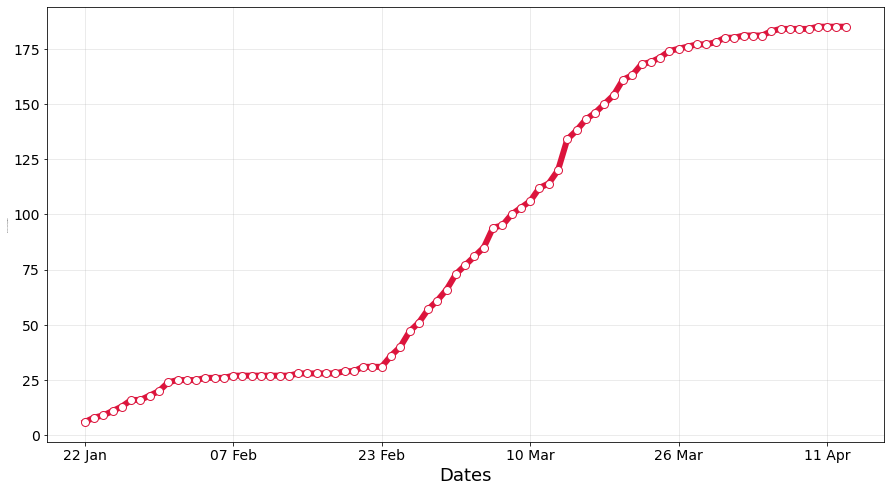

In [29]:
case_nums_country = df_confirmed.groupby("country").sum().drop(['Lat','Long'],axis =1).apply(lambda x: x[x > 0].count(), axis =0)
d = [datetime.strptime(date,'%m/%d/%y').strftime("%d %b") for date in case_nums_country.index]

f = plt.figure(figsize=(15,8))
f.add_subplot(111)
marker_style = dict(c="crimson",linewidth=6, linestyle='-', marker='o',markersize=8, markerfacecolor='#ffffff')
plt.plot(d, case_nums_country,**marker_style)
plt.tick_params(labelsize = 14)
plt.xticks(list(np.arange(0,len(d),int(len(d)/5))),d[:-1:int(len(d)/5)]+[d[-1]])

#labels
plt.xlabel("Dates",fontsize=18)
plt.ylabel("Number of Countries/Regions",fontsize=1)
plt.grid(alpha = 0.3)

plt.savefig(out+'spread.png')
plt.show()
plt.close()

### 1 . COVID-19 Spread Trends in Different Continents

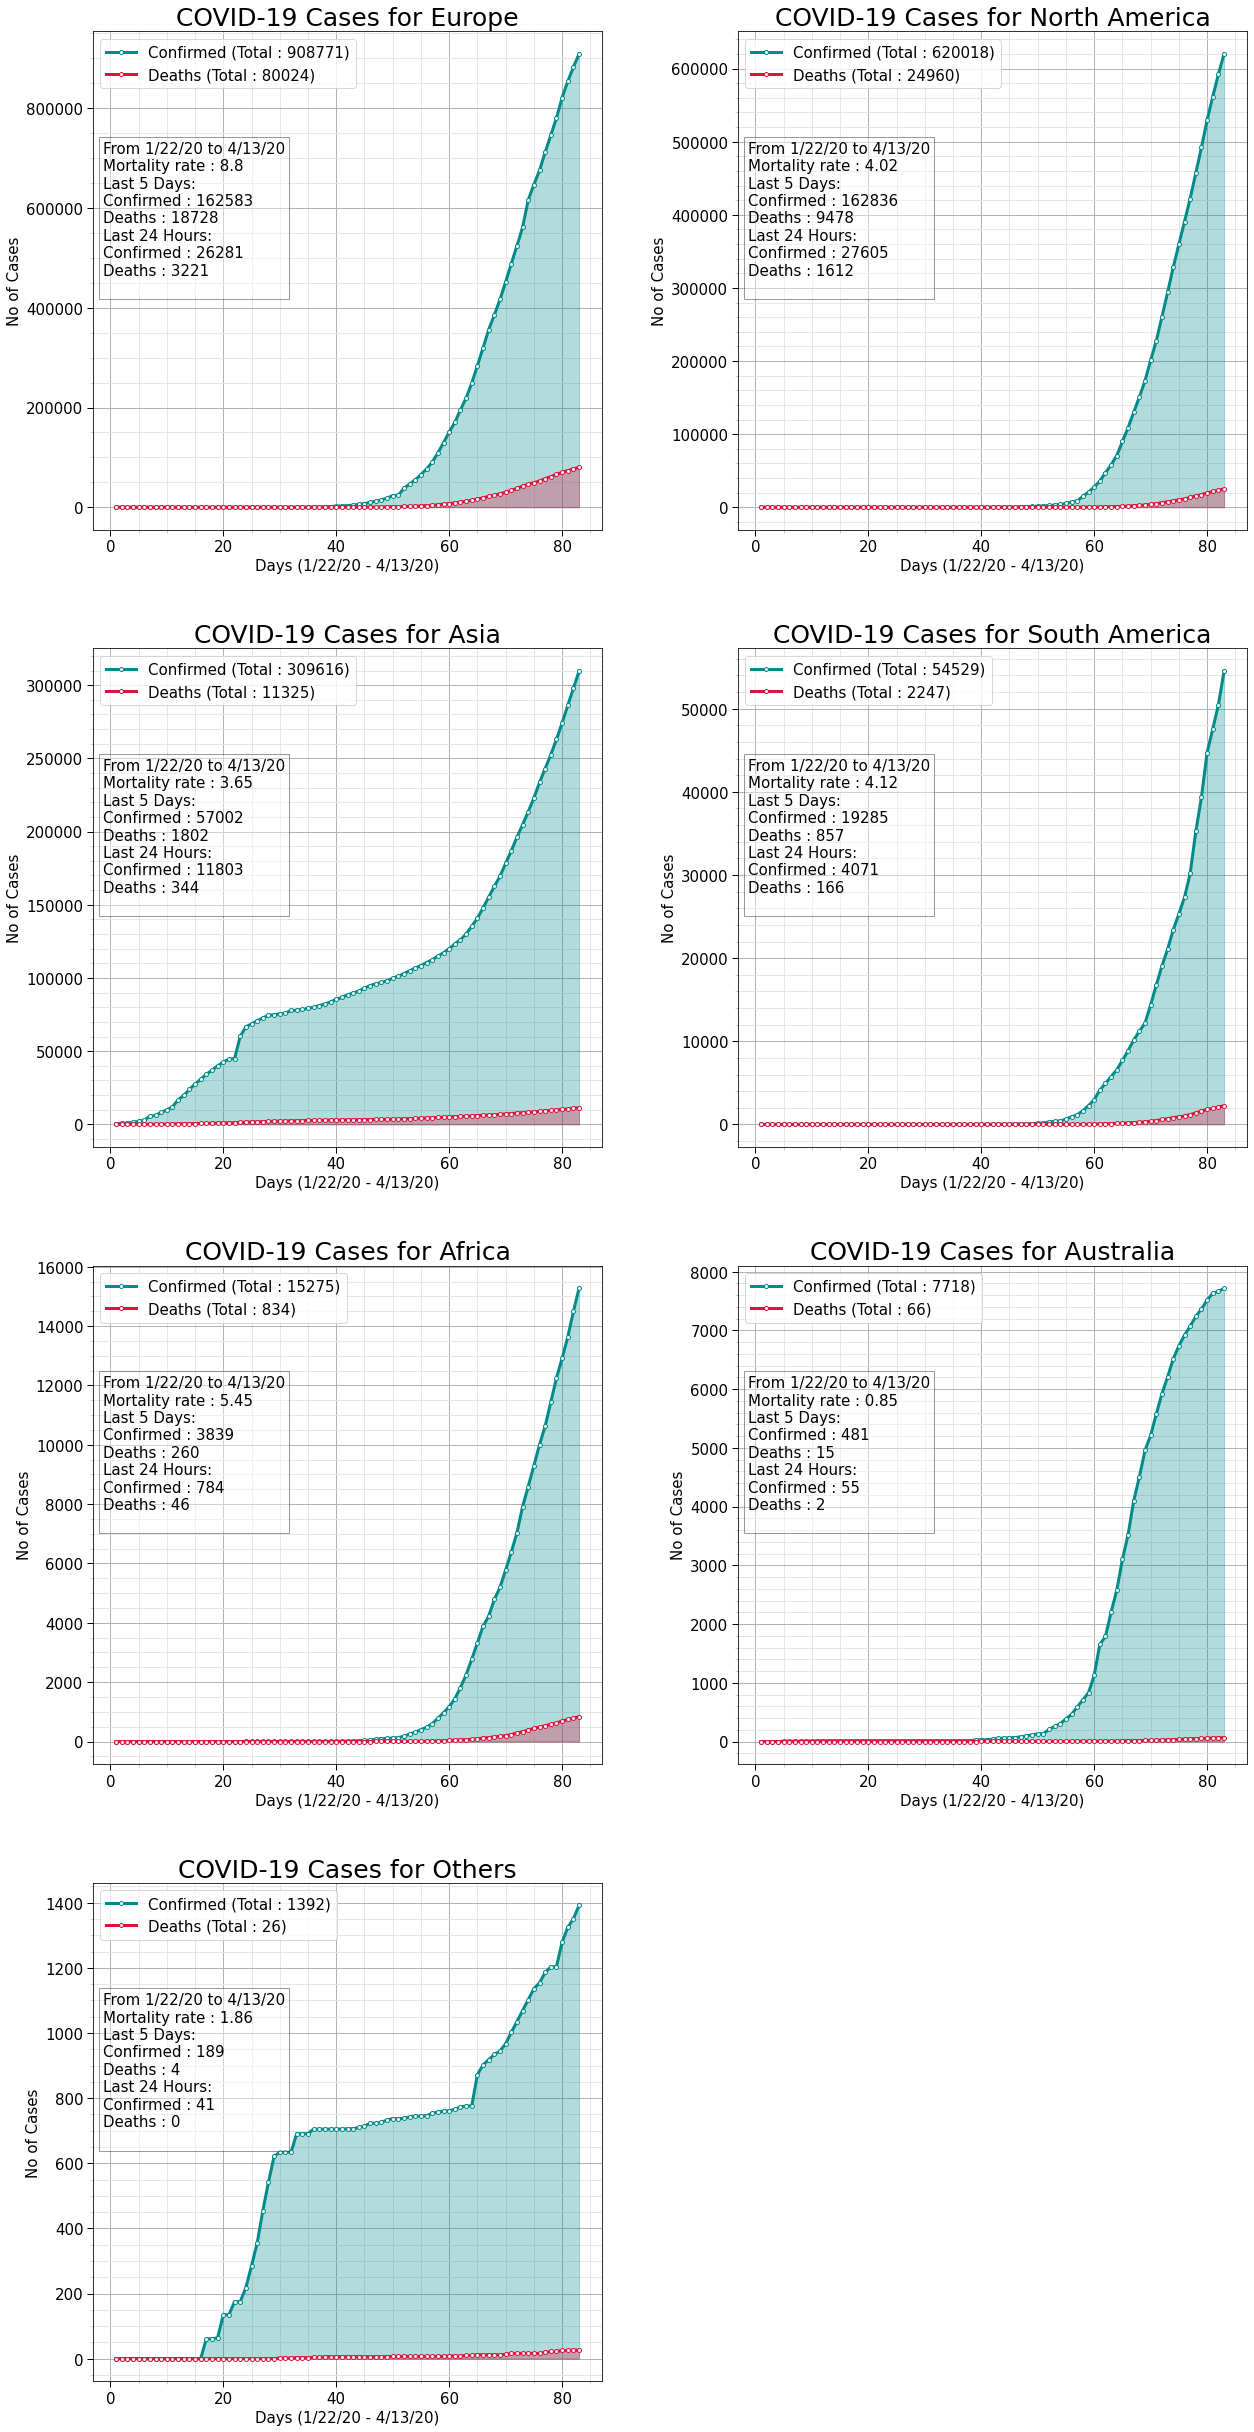

In [31]:
df_continents= df_confirmed.groupby(["continent"]).sum()
continents = df_continents.sort_values(df_continents.columns[-1],ascending = False).index

cols =2
rows = int(np.ceil(continents.shape[0]/cols))
f = plt.figure(figsize=(20,9*rows))
for i,continent in enumerate(continents):
    visualize_covid_cases(df_confirmed, df_deaths, continent = continent,figure = [f,rows,cols, i+1])

plt.show()

### 4. COVID-19 Spread Comparison of few most affected countries and INDIA

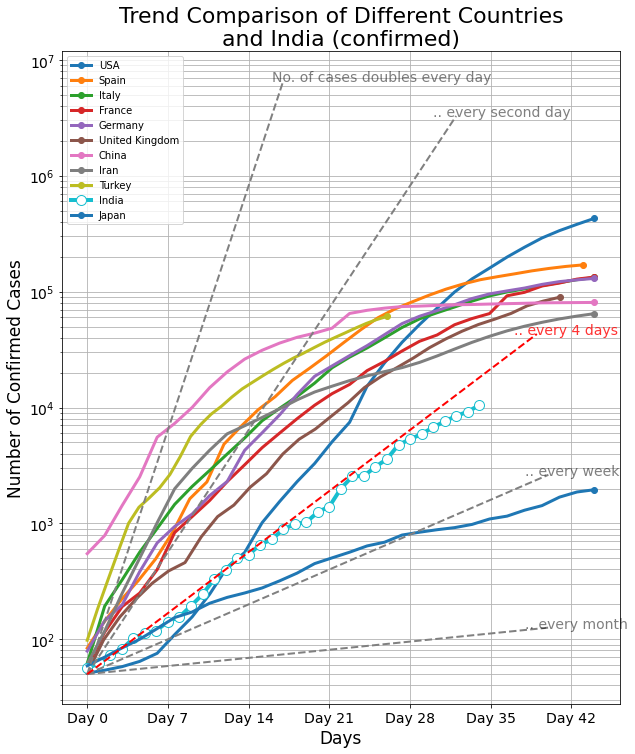

In [33]:
temp = df_confirmed.groupby('country').sum().drop(["Lat","Long"],axis =1).sort_values(df_confirmed.columns[-1], ascending= False)

threshold = 50
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i >= 9:
        if country != "India" and country != "Japan" :
            continue
    days = 45
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:days]
     
    date = np.arange(0,len(t[:days]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    if country != "India":
        plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])
    else:
        marker_style = dict(linewidth=4, linestyle='-', marker='o',markersize=10, markerfacecolor='#ffffff')
        plt.plot(date,t,"-.",label = country,**marker_style)

plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,days,7),[ "Day "+str(i) for i in range(days)][::7])     

# Reference lines 
x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,int(days-12))
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every second day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,int(days-4))
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,int(days-4))
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)


# India is following trend similar to doulbe the cases in 4 days but it may increase the rate 
x = np.arange(0,int(days-5))
y = 2**(x/4+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "Red")
plt.annotate(".. every 4 days",(x[-3],y[-1]),color="Red",xycoords="data",fontsize=14,alpha = 0.8)

# plot Params
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Confirmed Cases",fontsize=17)
plt.title("Trend Comparison of Different Countries\n and India (confirmed) ",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.savefig(out+'Trend Comparison with India (confirmed).png')
plt.show()

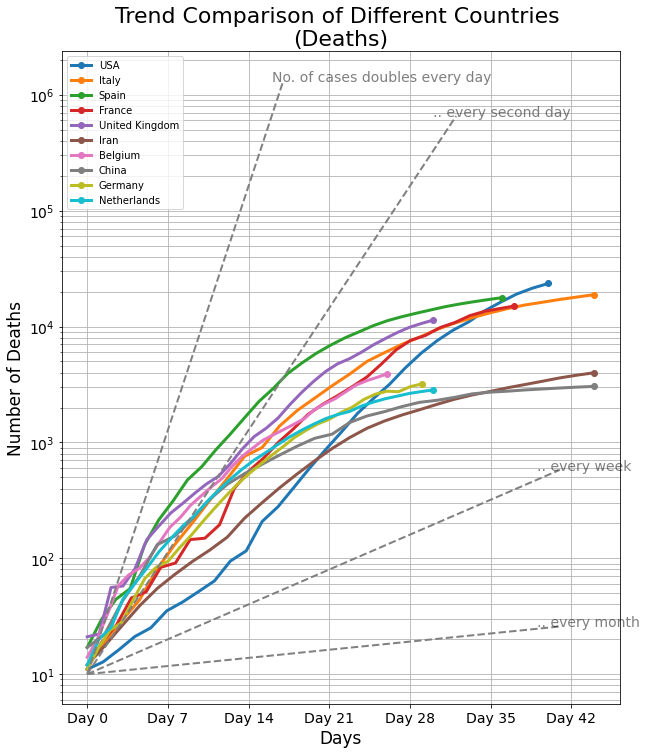

In [34]:
temp = df_deaths.groupby('country').sum().drop(["Lat","Long"],axis =1).sort_values(df_deaths.columns[-1], ascending= False)

threshold = 10
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i >= 10:
        break
    days = 45
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:days]
     
    date = np.arange(0,len(t[:days]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])


plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,days,7),[ "Day "+str(i) for i in range(days)][::7])     

# Reference lines 
x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-12)
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every second day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-3)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-3)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

# plot Params
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Deaths",fontsize=17)
plt.title("Trend Comparison of Different Countries \n(Deaths)",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.savefig(out+'Trend Comparison countries deaths.png')
plt.show()

*COVID-19 Spread Comparison of in different continents*

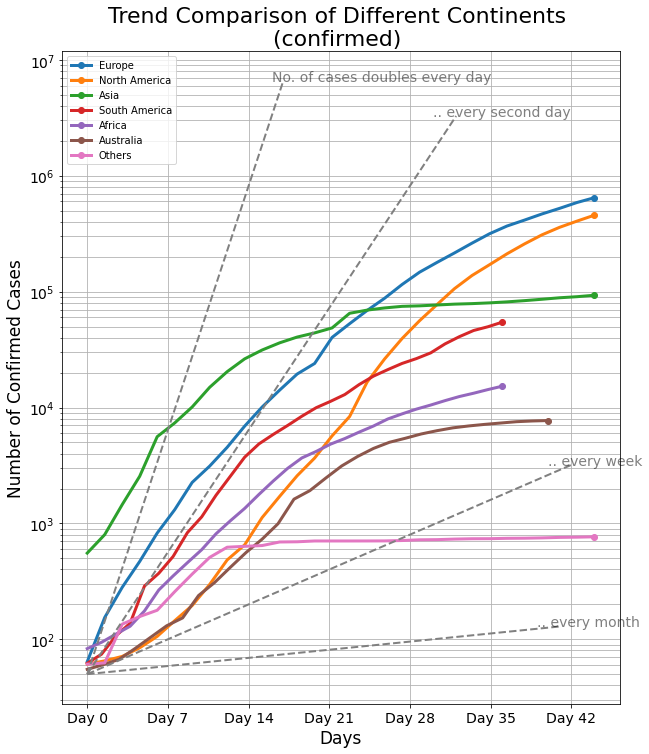

In [35]:
temp = df_confirmed.groupby('continent').sum().drop(["Lat","Long"],axis =1).sort_values(df_confirmed.columns[-1], ascending= False)

threshold = 50
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i >= 10:
        break
    days = 45
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:days]
     
    date = np.arange(0,len(t[:days]))
    xnew = np.linspace(date.min(), date.max(), 30)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])

plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,days,7),[ "Day "+str(i) for i in range(days)][::7])     

# Reference lines 
x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-12)
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every second day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-2)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-3)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)


# plot Params
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Confirmed Cases",fontsize=17)
plt.title("Trend Comparison of Different Continents \n(confirmed) ",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.savefig(out+'Trend Comparison of continents (Confirmed).png')
plt.show()

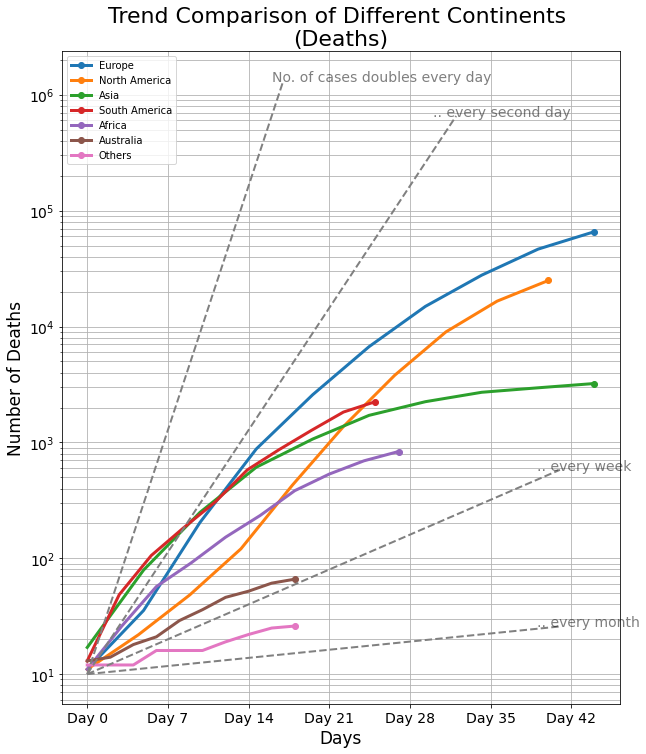

In [36]:
temp = df_deaths.groupby('continent').sum().drop(["Lat","Long"],axis =1).sort_values(df_deaths.columns[-1], ascending= False)

threshold = 10
f = plt.figure(figsize=(10,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    if i >= 10:
        break
    days = 45
    t = temp.loc[temp.index== country].values[0]
    t = t[t>threshold][:days]
     
    date = np.arange(0,len(t[:days]))
    xnew = np.linspace(date.min(), date.max(), 10)
    spl = make_interp_spline(date, t, k=1)  # type: BSpline
    power_smooth = spl(xnew)
    plt.plot(xnew,power_smooth,'-o',label = country,linewidth =3, markevery=[-1])


plt.tick_params(labelsize = 14)        
plt.xticks(np.arange(0,days,7),[ "Day "+str(i) for i in range(days)][::7])     

# Reference lines 
x = np.arange(0,18)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of cases doubles every day",(x[-2],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-12)
y = 2**(x/2+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every second day",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-3)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every week",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days-3)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. every month",(x[-3],y[-1]),xycoords="data",fontsize=14,alpha = 0.5)

# plot Params
plt.xlabel("Days",fontsize=17)
plt.ylabel("Number of Deaths",fontsize=17)
plt.title("Trend Comparison of Different Continents \n(Deaths)",fontsize=22)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.savefig(out+'Trend Comparison continents (deaths).png')
plt.show()

# Global Prediction
<hr>

## Global Trend: 
It is useful to understand the global trend of an increase in the number of cases over time. There is always a pattern in any data, but the concern is how strongly data follows a pattern. COVID-19 spreads exponentially, positive cases of COVID-19 takes 67 days to reach 1 Lakhs while it takes only 11 days to reach 2 Lakhs, 4 days to reach 3 Lakhs, and just 2 days to reach 5 Lakhs. This trend shows how fast it spreads.
<br><br>
**Note: This prediction is only based on the current spread trend, and no other factor is included, so this trend may vary a lot. Also, at some point in time, the testing capacity will become the limiting factor, so it may affect the actual figure a lot. This is to estimate the possible values that could reach with the consideration of any measures taken by different countries to control the spread.**  

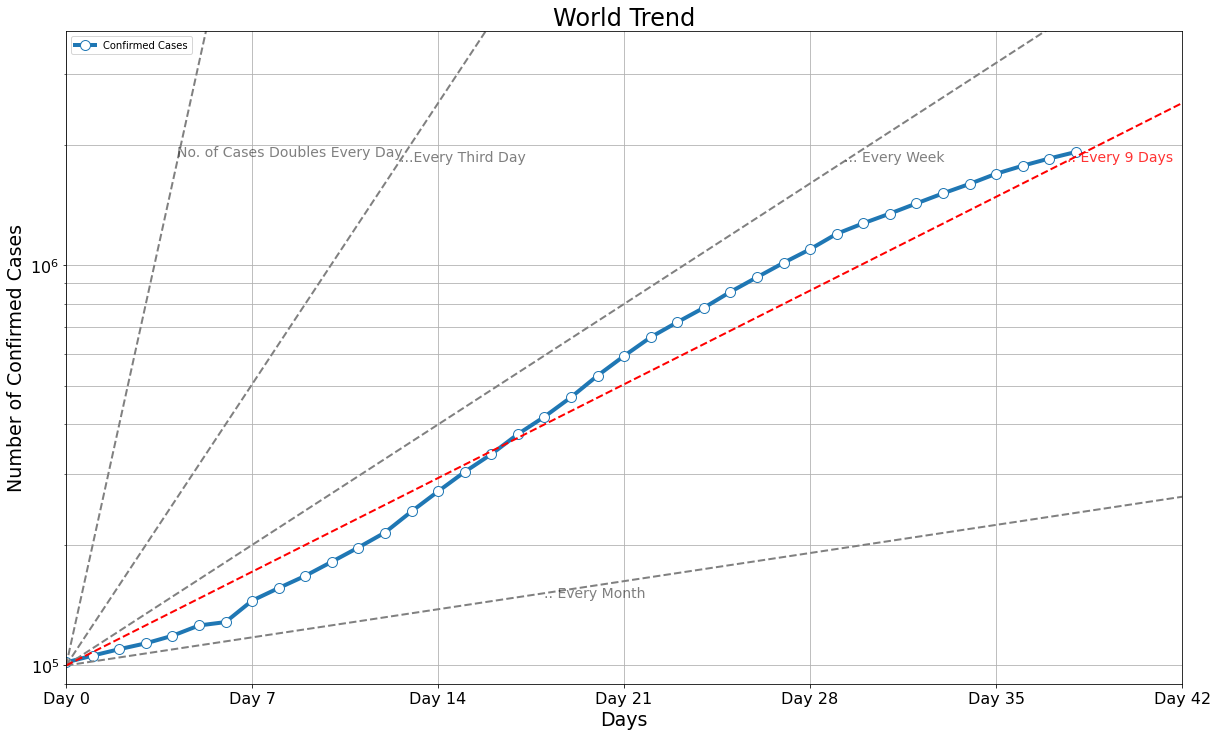

In [37]:
temp_data = df_confirmed.iloc[:,5:].sum(axis =0)
f = plt.figure(figsize=(20,12))
f.add_subplot(111)

threshold = 100000

t = temp_data.values
t = t[t >threshold]

date = np.arange(0,len(t[:]))
xnew = np.linspace(date.min(), date.max(), 10)
spl = make_interp_spline(date, t, k=1)  # type: BSpline
power_smooth = spl(xnew)

marker_style = dict(linewidth=4, linestyle='-', marker='o',markersize=10, markerfacecolor='#ffffff')
plt.plot(date,t,"-.",label="Confirmed Cases",**marker_style)

days  = 52
# Reference lines 
x = np.arange(0,days)
y = 2**(x+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("No. of Cases Doubles Every Day",(np.log2((t.max()-threshold)/threshold),t.max()-threshold/2),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days)
y = 2**(x/3+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("...Every Third Day",(np.log2((t.max()-threshold)/threshold)*3,t.max()-threshold),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days)
y = 2**(x/7+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate("... Every Week",(np.log2((t.max()-threshold)/threshold)*7,t.max()-threshold),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days)
y = 2**(x/30+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "gray")
plt.annotate(".. Every Month",(18,2**(17/30+np.log2(threshold))),xycoords="data",fontsize=14,alpha = 0.5)

x = np.arange(0,days)
y = 2**(x/9+np.log2(threshold))
plt.plot(x,y,"--",linewidth =2,color = "Red")
plt.annotate(".. Every 9 Days",(np.log2((t.max()-threshold)/threshold)*9,t.max()-threshold),color="Red",xycoords="data",fontsize=14,alpha = 0.8)


plt.xlim(date[0],date[-1])
plt.ylim(threshold - threshold/10,2*t.max())
# plot Params
# plt.tight_layout()
plt.tick_params(labelsize = 16)        
plt.xticks(np.arange(0,len(t[:])+7,7),[ "Day "+str(i) for i in range(len(t[:])+7)][::7]) 
plt.xlabel("Days",fontsize=19)
plt.ylabel("Number of Confirmed Cases",fontsize=19)
plt.title("World Trend",fontsize=24)
plt.legend(loc = "upper left")
plt.yscale("log")
plt.grid(which="both")
plt.savefig(out+"World Trend Confirmed cases.png")
plt.show()

## Prediction Curve for Global Confirmed Cases
Buliding Model

In [38]:
# Visible = Input(shape=(1,))
# Dense_l1 = Dense(80,name="Dense_l1")(Visible)
# LRelu_l1 = LeakyReLU(name = "LRelu_l1")(Dense_l1)

# Dense_l2 = Dense(80,name = "Dense_l2")(LRelu_l1)
# LRelu_l2 = LeakyReLU(name = "LRelu_l2")(Dense_l2)

# Dense_l3 = Dense(80,name = "Dense_l3")(LRelu_l2)
# LRelu_l3 = LeakyReLU(name = "LRelu_l3")(Dense_l3)

# Dense_l4 = Dense(1,name="Dense_l4")(LRelu_l3)
# LRelu_l4 = LeakyReLU(name = "Output")(Dense_l4
#                                      )
# model = models.Model(inputs=Visible, outputs=LRelu_l4)
# model.compile(optimizer=Adam(lr=0.001), 
#               loss='mean_squared_error',
#               metrics=['accuracy'])
# model.summary()

In [39]:
data_y = np.log10(np.asarray(df_confirmed.iloc[:,5:].sum(axis =0)).astype("float32"))
data_x = np.arange(1,len(data_y)+1)

In [40]:
# epochs = 5000
# model.fit(data_x.reshape([data_y.shape[0],1]),data_y.reshape([data_y.shape[0],1]),epochs=epochs)

In [41]:
# model.save('model_confirmed_v2.h5')

#### Loading Model

In [42]:
model = models.load_model("model_confirmed_v2.h5")
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
Dense_l1 (Dense)             (None, 80)                160       
_________________________________________________________________
LRelu_l1 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l2 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l2 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l3 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l3 (LeakyReLU)         (None, 80)                0   

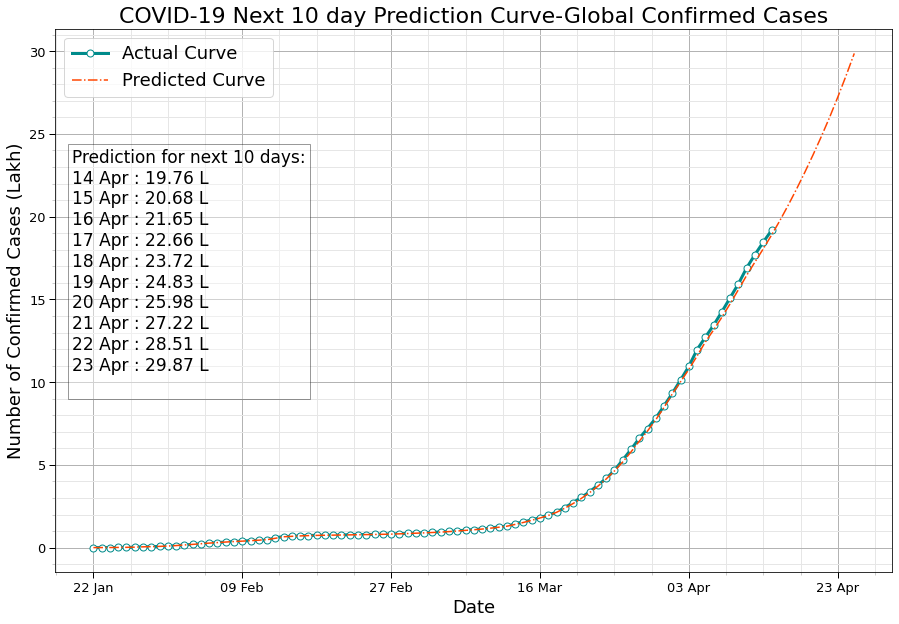

In [43]:
lakh = 100000
prediction_days = 10

temp_data = df_confirmed.iloc[:,5:].sum(axis =0)
data = np.power(10,model.predict(np.arange(1,len(temp_data)+prediction_days+1)))
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)

date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=7, markerfacecolor='#ffffff')
plt.plot(date,temp_data/lakh,"-.",color="darkcyan",**marker_style, label="Actual Curve")

date = np.arange(0,len(data))
plt.plot(date,data/lakh,"-.",color="orangered",label="Predicted Curve")

nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total = d + nextdays

text = "Prediction for next "+str(prediction_days) +" days:\n"
for i in range(prediction_days):
    text += nextdays[i]+" : "+str(np.round(data[-1*(prediction_days-i)],-3)[0]/lakh)+" L\n"

plt.text(0.02, 0.78, text, fontsize=17, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),d[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

# Plot Title
plt.title("COVID-19 Next 10 day Prediction Curve-Global Confirmed Cases",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Confirmed Cases (Lakh)",fontsize =18)

# plt.yscale("log")
plt.legend(fontsize =18)
plt.tick_params(labelsize = 13) 
plt.savefig(out+"Prediction Curve-Confirmed.png")
plt.show()

## Prediction Curve for Global Death Cases
Buliding Model

In [44]:
# Visible = Input(shape=(1,))
# Dense_l1 = Dense(80,name="Dense_l1")(Visible)
# LRelu_l1 = LeakyReLU(name = "LRelu_l1")(Dense_l1)

# Dense_l2 = Dense(80,name = "Dense_l2")(LRelu_l1)
# LRelu_l2 = LeakyReLU(name = "LRelu_l2")(Dense_l2)

# Dense_l3 = Dense(80,name = "Dense_l3")(LRelu_l2)
# LRelu_l3 = LeakyReLU(name = "LRelu_l3")(Dense_l3)

# Dense_l4 = Dense(1,name="Dense_l4")(LRelu_l3)
# LRelu_l4 = LeakyReLU(name = "Output")(Dense_l4
#                                      )
# model2 = models.Model(inputs=Visible, outputs=LRelu_l4)
# model2.compile(optimizer=Adam(lr=0.001), 
#               loss='mean_squared_error',
#               metrics=['accuracy'])
# model2.summary()

In [45]:
data1_y = np.log10(np.asarray(df_deaths.iloc[:,5:].sum(axis =0)).astype("float32"))
data1_x = np.arange(1,len(data1_y)+1)

In [46]:
# epochs=5000
# model2.fit(data1_x.reshape([data1_y.shape[0],1]),data1_y.reshape([data1_y.shape[0],1]),epochs=epochs)

In [47]:
# model2.save('model_deaths_v2.h5')

#### Loading Model

In [48]:
model2 = models.load_model("model_deaths_v2.h5")
model2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
Dense_l1 (Dense)             (None, 80)                160       
_________________________________________________________________
LRelu_l1 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l2 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l2 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l3 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l3 (LeakyReLU)         (None, 80)                0   

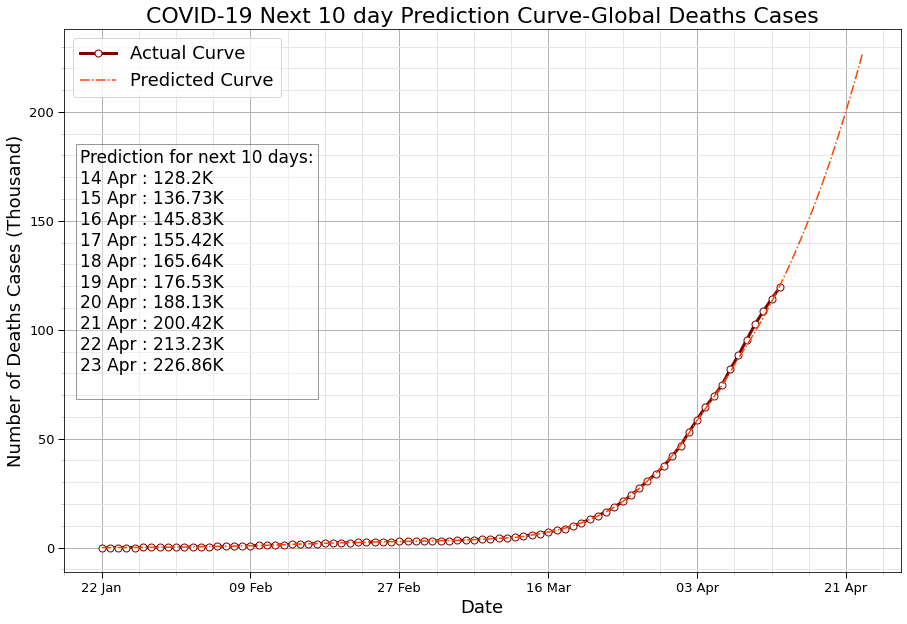

In [49]:
thousand = 1000
prediction_days = 10

temp_data = df_deaths.iloc[:,5:].sum(axis =0)
data = np.power(10,model2.predict(np.arange(1,len(temp_data)+prediction_days+1)))
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)


date = np.arange(0,len(temp_data))
# xnew = np.linspace(date.min(), date.max(), 10)
# spl = make_interp_spline(date, t, k=1)  # type: BSpline
# power_smooth = spl(xnew)

marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=7, markerfacecolor='#ffffff')
plt.plot(date,temp_data/thousand,"-.",color="maroon",**marker_style, label="Actual Curve")

date = np.arange(0,len(data))
plt.plot(date,data/thousand,"-.",color="orangered",label="Predicted Curve")

nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

text = "Prediction for next "+str(prediction_days) +" days:\n"
for i in range(prediction_days):
    text += nextdays[i]+" : "+str(np.round(data[-1*(prediction_days-i)],-1)[0]/thousand)+"K\n"

plt.text(0.02, 0.78, text, fontsize=17, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=12)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

# Plot Title
plt.title("COVID-19 Next 10 day Prediction Curve-Global Deaths Cases",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Deaths Cases (Thousand)",fontsize =18)

# plt.yscale("log")
plt.legend(fontsize =18)
plt.tick_params(labelsize = 13) 
plt.savefig(out+"Prediction Curve2.png")
plt.show()

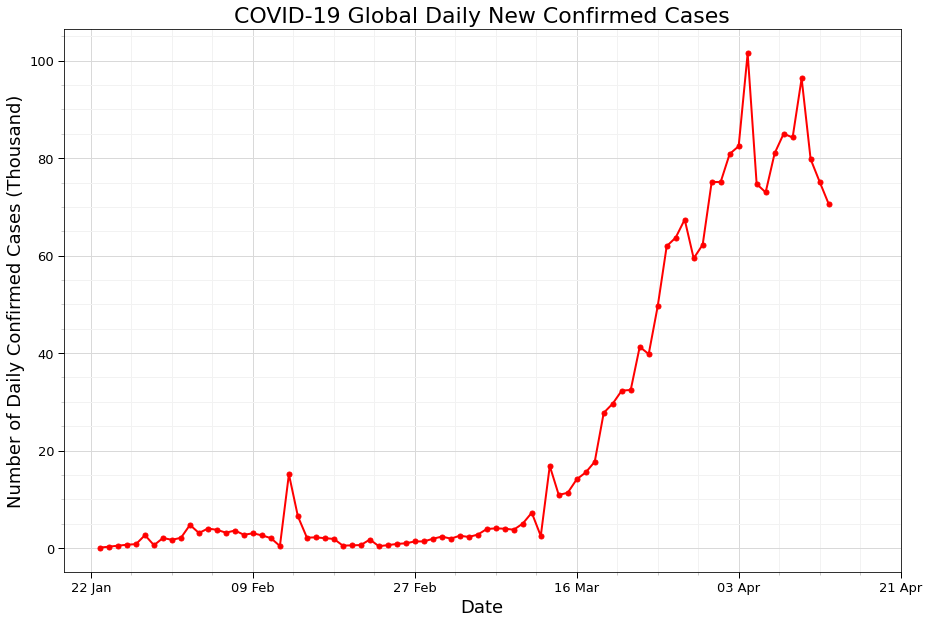

In [51]:
# Data
temp_data = np.nan_to_num(df_confirmed.sum()[5:].diff())


# Plot
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)


date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=2, linestyle='-', marker='o',markersize=5)
plt.plot(date,temp_data/thousand,"-.",color="red",**marker_style)


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=12)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.85", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.95", which = 'minor')

# Plot Title
plt.title("COVID-19 Global Daily New Confirmed Cases",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Confirmed Cases (Thousand)",fontsize =18)

# plt.yscale("log")
plt.tick_params(labelsize = 13) 
plt.savefig(out+"daily confirmed cases global.png")
plt.show()

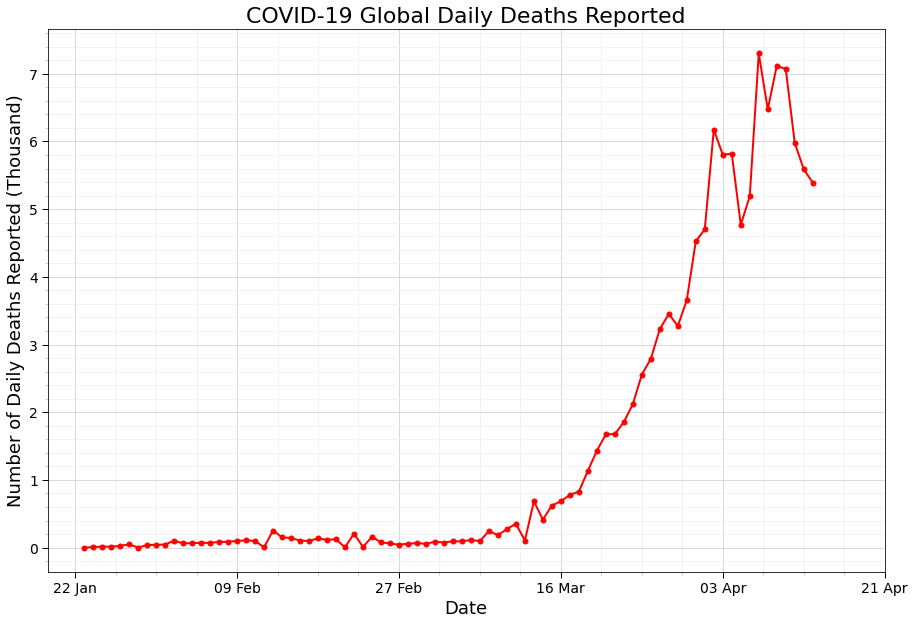

In [52]:
# Data
temp_data = np.nan_to_num(df_deaths.sum()[5:].diff())


# Plot
f = plt.figure(figsize=(15,10))
ax = f.add_subplot(111)


date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=2, linestyle='-', marker='o',markersize=5)
plt.plot(date,temp_data/thousand,"-.",color="red",**marker_style)


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.85", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.95", which = 'minor')

# Plot Title
plt.title("COVID-19 Global Daily Deaths Reported",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Deaths Reported (Thousand)",fontsize =18)

# plt.yscale("log")
plt.savefig(out+"daily deaths cases Global.png")
plt.show()

## 2.Daily New Cases in Different Countries

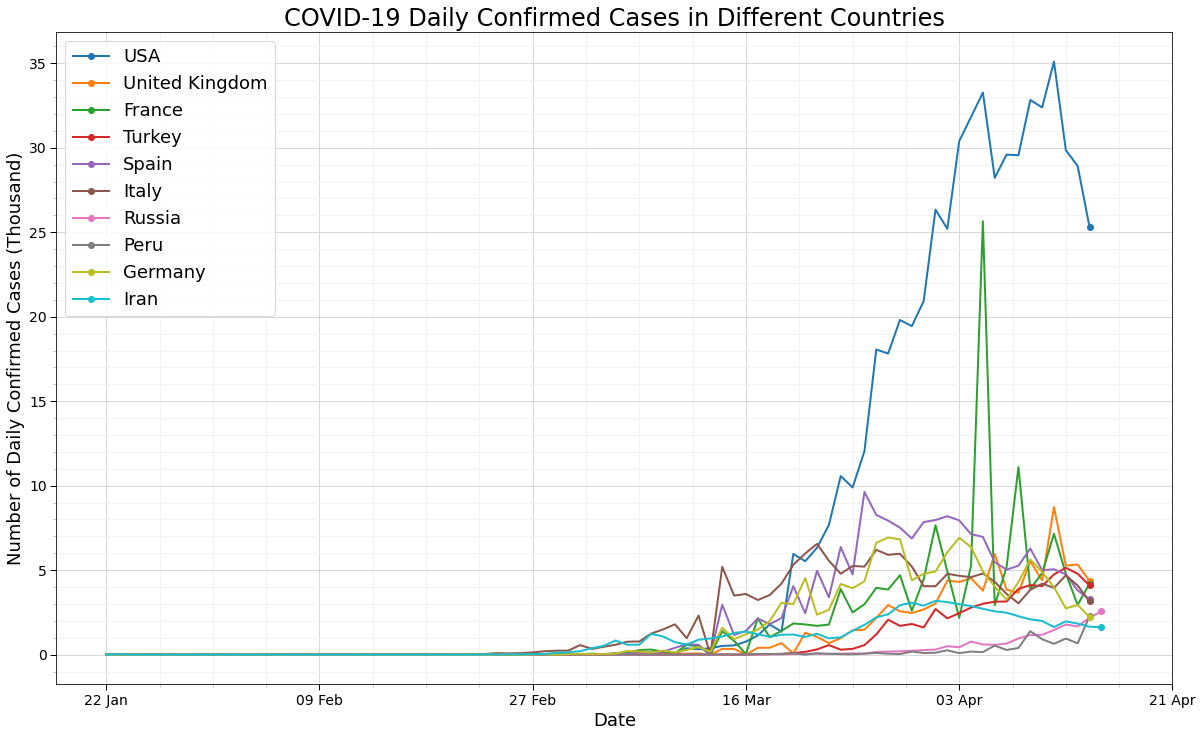

In [53]:
thoudand = 1000
temp = df_confirmed.groupby('country').sum().diff(axis=1).sort_values(df_deaths.columns[-1],ascending =False).head(10).replace(np.nan,0)
threshold = 0
f = plt.figure(figsize=(20,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    t = temp.loc[temp.index== country].values[0]
    t = t[t>=threshold]
    
    date = np.arange(0,len(t[:]))
    plt.plot(date,t/thoudand,'-o',label = country,linewidth =2, markevery=[-1])


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.85", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.95", which = 'minor')

# Plot Title
plt.title("COVID-19 Daily Confirmed Cases in Different Countries",{'fontsize':24})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Confirmed Cases (Thousand)",fontsize =18)

# plt.yscale("log")
plt.legend(fontsize=18) 
plt.savefig(out+"daily confirmed cases countrywise.png")
plt.show()

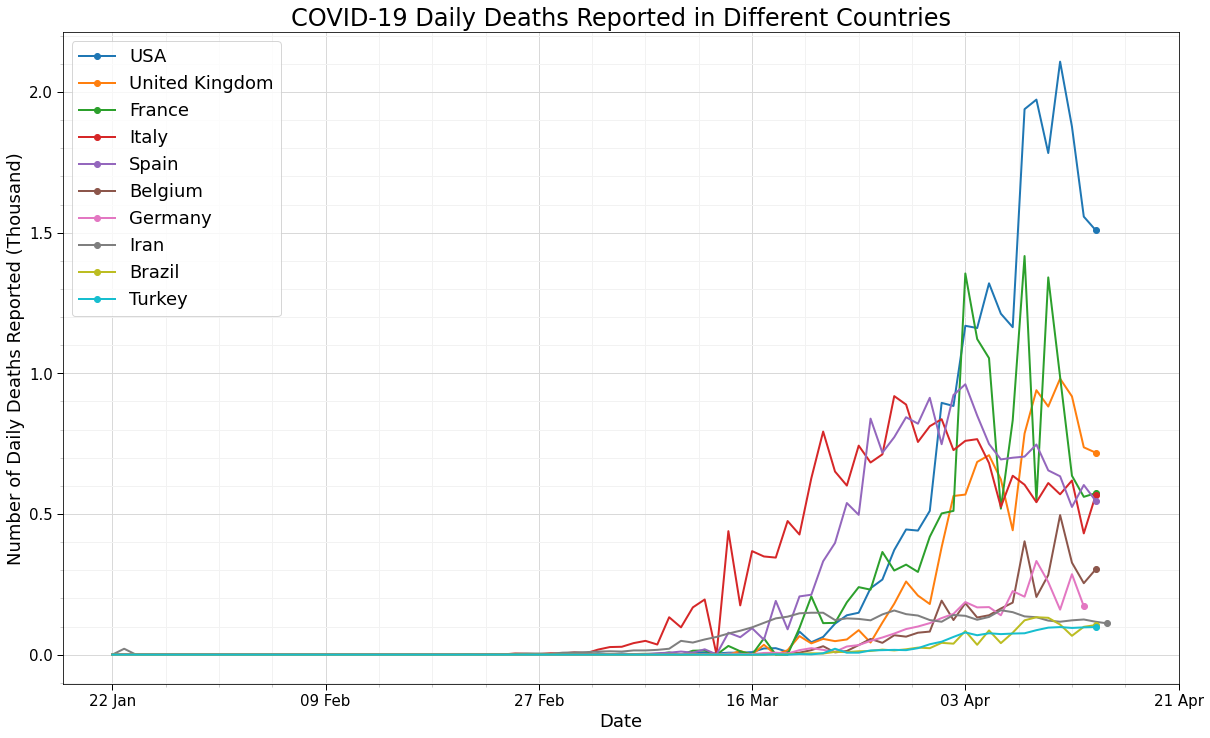

In [54]:
thoudand = 1000
temp = df_deaths.groupby('country').sum().diff(axis=1).sort_values(df_deaths.columns[-1],ascending =False).head(10).replace(np.nan,0)
threshold = 0
f = plt.figure(figsize=(20,12))
ax = f.add_subplot(111)
for i,country in enumerate(temp.index):
    t = temp.loc[temp.index== country].values[0]
    t = t[t>=threshold]
    
    date = np.arange(0,len(t[:]))
    plt.plot(date,t/thoudand,'-o',label = country,linewidth =2, markevery=[-1])


nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=15)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.85", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.95", which = 'minor')

# Plot Title
plt.title("COVID-19 Daily Deaths Reported in Different Countries",{'fontsize':24})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Daily Deaths Reported (Thousand)",fontsize =18)

# plt.yscale("log")
plt.legend(fontsize=18) 
plt.savefig(out+"daily deaths reported countrywise.png")
plt.show()

# COVID-19 : USA

### Prediction Curve for USA

In [101]:
# Visible = Input(shape=(1,))
# Dense_l1 = Dense(80,name="Dense_l1")(Visible)
# LRelu_l1 = LeakyReLU(name = "LRelu_l1")(Dense_l1)
# Dense_l2 = Dense(80,name = "Dense_l2")(LRelu_l1)
# LRelu_l2 = LeakyReLU(name = "LRelu_l2")(Dense_l2)
# Dense_l3 = Dense(1,name="Dense_l3")(LRelu_l2)
# LRelu_l3 = LeakyReLU(name = "Output")(Dense_l3)
# model_usa_c = models.Model(inputs=Visible, outputs=LRelu_l3)
# model_usa_c.compile(optimizer=Adam(lr=0.0001), 
#               loss='mean_squared_error',
#               metrics=['accuracy'])
# model_usa_c.summary()

In [102]:
# model_usa_c.save('model_usa_c.h5')

In [103]:
# df_temp = df_confirmed.groupby(["country"]).sum()
# df_temp = np.asarray(df_temp[df_temp.index == "USA"].iloc[:,2:])[0]
# data_y = np.log(df_temp).astype("float32")
# data_x = np.arange(1,len(data_y)+1)
# data_x.shape[0]

In [104]:
# epochs = 3000
# model_usa_c.fit(data_x.reshape([data_x.shape[0],1]),data_y.reshape([data_x.shape[0],1]),epochs=epochs,batch_size=64)

In [105]:
model_usa_c = models.load_model("model_usa_c.h5")
model_usa_c.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
Dense_l1 (Dense)             (None, 80)                160       
_________________________________________________________________
LRelu_l1 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l2 (Dense)             (None, 80)                6480      
_________________________________________________________________
LRelu_l2 (LeakyReLU)         (None, 80)                0         
_________________________________________________________________
Dense_l3 (Dense)             (None, 1)                 81        
_________________________________________________________________
Output (LeakyReLU)           (None, 1)                 0   

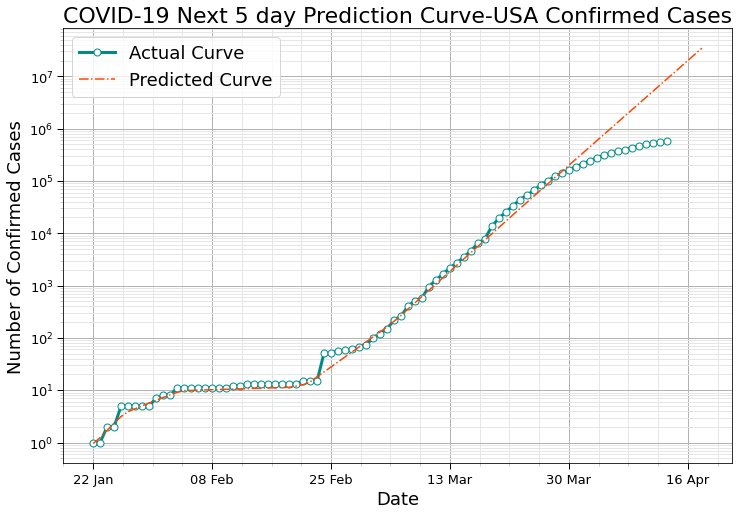

In [106]:
lakh = 100000
prediction_days = 5
data = np.power(2,model_usa_c.predict(np.arange(1,len(data_y)+prediction_days+1)))
df_temp = df_confirmed.groupby(["country"]).sum()
temp_data = np.asarray(df_temp[df_temp.index == "USA"].iloc[:,2:])[0]
# temp_data = df_confirmed.iloc[:,5:].sum(axis =0)
f = plt.figure(figsize=(12,8))
ax = f.add_subplot(111)

date = np.arange(0,len(temp_data))

marker_style = dict(linewidth=3, linestyle='-', marker='o',markersize=7, markerfacecolor='#ffffff')
plt.plot(date,temp_data,"-.",color="darkcyan",**marker_style, label="Actual Curve")

date = np.arange(0,len(data))
plt.plot(date,data,"-.",color="orangered",label="Predicted Curve")

nextdays = [(datetime.strptime(d[-1],'%d %b')+timedelta(days=i)).strftime("%d %b") for i in range(1,prediction_days+1)]
total =d+nextdays

text = "Prediction for next "+str(prediction_days) +" days:\n"
for i in range(prediction_days):
    text += nextdays[i]+" : "+str(np.round(data[-1*(prediction_days-i)],-3)[0]/lakh)+" L\n"

# plt.text(0.02, 0.78, text, fontsize=17, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes,bbox=dict(facecolor='white', alpha=0.4))

# X-axis
plt.xticks(list(np.arange(0,len(total),int(len(total)/5))),total[:-1:int(len(total)/5)]+[total[-1]])

# Tick-Parameters
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.tick_params(which='both', width=1,labelsize=14)
ax.tick_params(which='major', length=6)
ax.tick_params(which='minor', length=3, color='0.8')

# Grid
plt.grid(lw = 1, ls = '-', c = "0.7", which = 'major')
plt.grid(lw = 1, ls = '-', c = "0.9", which = 'minor')

# Plot Title
plt.title("COVID-19 Next 5 day Prediction Curve-USA Confirmed Cases",{'fontsize':22})

# Axis Lable
plt.xlabel("Date",fontsize =18)
plt.ylabel("Number of Confirmed Cases",fontsize =18)

plt.yscale("log")
plt.legend(fontsize =18)
plt.tick_params(labelsize = 13) 
plt.savefig(out+"Prediction Curve-Confirmed (USA).png")
plt.show()